written by Hazwan Adhikara

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string

from wordcloud import WordCloud
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Bidirectional, Embedding, Dense, Dropout, 
                                     GlobalAveragePooling1D, Conv1D, 
                                     GlobalMaxPooling1D, SimpleRNN, 
                                     LSTM, GRU, SpatialDropout1D)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import classification_report, f1_score, confusion_matrix


## Data Preparation

In [2]:
train = pd.read_csv('./data/train.csv', encoding='latin-1')
test = pd.read_csv('./data/test.csv', encoding='latin-1')

print("Train shape:", train.shape)
print("Test shape:", test.shape)

display(train.head())
display(test.head())

Train shape: (27481, 10)
Test shape: (3532, 8)


,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


,textID,text,Time of Tweet,Age of User,Country,Population -2020,Land Area (Kmï¿½),Density (P/Kmï¿½)
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,morning,0-20,Afghanistan,38928346,652860.0,60
1,96d74cb729,Shanghai is also really exciting (precisely -...,noon,21-30,Albania,2877797,27400.0,105
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",night,31-45,Algeria,43851044,2381740.0,18
3,01082688c6,happy bday!,morning,46-60,Andorra,77265,470.0,164
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,noon,60-70,Angola,32866272,1246700.0,26


In [3]:
train.info()

train.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            27481 non-null  object 
 1   text              27480 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         27481 non-null  object 
 4   Time of Tweet     27481 non-null  object 
 5   Age of User       27481 non-null  object 
 6   Country           27481 non-null  object 
 7   Population -2020  27481 non-null  int64  
 8   Land Area (Km²)   27481 non-null  float64
 9   Density (P/Km²)   27481 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


,Population -2020,Land Area (Km²),Density (P/Km²)
count,2.748100e+04,2.748100e+04,27481.000000
mean,4.018497e+07,6.621730e+05,357.686583
std,1.504946e+08,1.807425e+06,2013.750702
min,8.010000e+02,0.000000e+00,2.000000
25%,1.968001e+06,2.281000e+04,35.000000
50%,8.655535e+06,1.118900e+05,89.000000
75%,2.843594e+07,5.279700e+05,214.000000
max,1.439324e+09,1.637687e+07,26337.000000


In [4]:
train.isna().sum()

textID              0
text                1
selected_text       1
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [5]:
bad_idx = train[train['text'].isna() & train['selected_text'].isna()].index
print("Missing Value Rows:", bad_idx.tolist())

train = train.dropna(subset=['text', 'selected_text']).reset_index(drop=True)

Missing Value Rows: [314]


ternyata hanya ada 1 row yang nilainya missing sehingga say putuskan untuk drop saja

In [6]:
train.isna().sum()

textID              0
text                0
selected_text       0
sentiment           0
Time of Tweet       0
Age of User         0
Country             0
Population -2020    0
Land Area (Km²)     0
Density (P/Km²)     0
dtype: int64

In [7]:
print("Train shape:", train.shape)

Train shape: (27480, 10)


## Exploratory Data Analysis

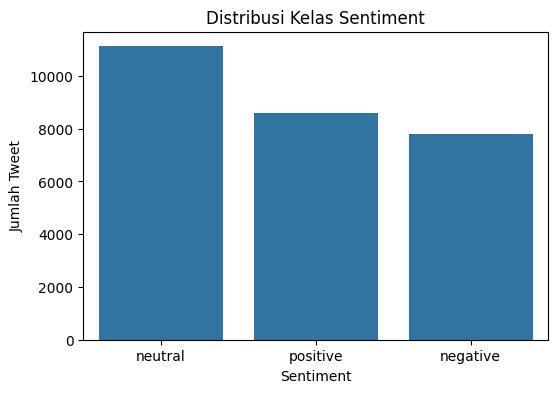

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=train, x='sentiment', order=train['sentiment'].value_counts().index)
plt.title('Distribusi Kelas Sentiment')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Sentiment')
plt.show()


terlihat dari data bahwa jumlah tweet terbanyak masuk ke sentiment netral, kedua positif lalu terakhir negatif

           char_len      word_len
count  27480.000000  27480.000000
mean      68.354949     12.902875
std       35.624417      6.925938
min        3.000000      1.000000
25%       39.000000      7.000000
50%       64.000000     12.000000
75%       97.000000     18.000000
max      159.000000     33.000000


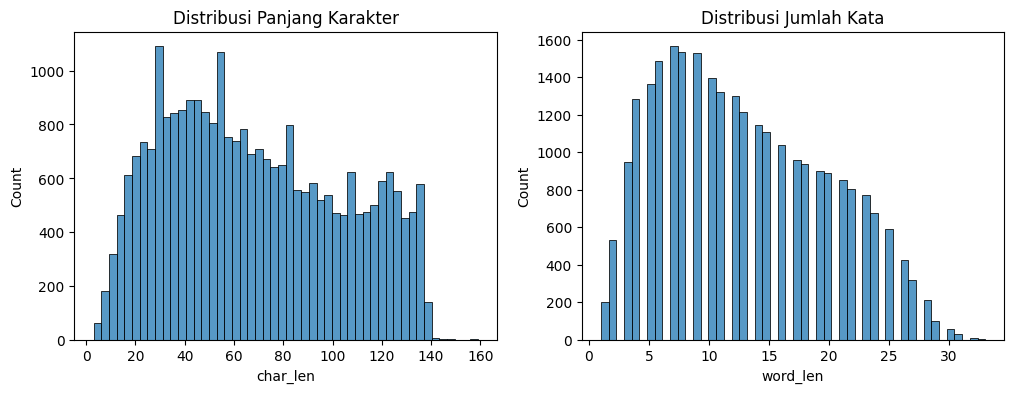

In [9]:
# Hitung jumlah kata & karakter
train['char_len'] = train['text'].str.len()
train['word_len'] = train['text'].str.split().str.len()

# Statistik panjang
print(train[['char_len','word_len']].describe())

# Visualisasi
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(train['char_len'], bins=50, ax=axes[0])
axes[0].set_title('Distribusi Panjang Karakter')
sns.histplot(train['word_len'], bins=50, ax=axes[1])
axes[1].set_title('Distribusi Jumlah Kata')
plt.show()



Top 20 kata untuk sentiment neutral:
[('i', 6207), ('to', 4152), ('the', 3554), ('a', 2552), ('it', 2026), ('my', 2016), ('you', 1958), ('and', 1876), ('in', 1606), ('is', 1515), ('for', 1439), ('s', 1288), ('on', 1283), ('of', 1251), ('t', 1241), ('but', 1145), ('me', 1129), ('that', 1061), ('have', 1012), ('just', 923)]

Top 20 kata untuk sentiment negative:
[('i', 5792), ('to', 2900), ('the', 2463), ('my', 2043), ('a', 1825), ('it', 1642), ('and', 1595), ('is', 1349), ('t', 1274), ('in', 1134), ('you', 1053), ('that', 1022), ('me', 1003), ('so', 985), ('s', 954), ('m', 918), ('of', 908), ('for', 881), ('not', 822), ('on', 802)]

Top 20 kata untuk sentiment positive:
[('i', 4669), ('the', 3015), ('to', 2980), ('a', 2417), ('you', 2338), ('it', 1738), ('and', 1694), ('my', 1488), ('s', 1395), ('for', 1337), ('day', 1259), ('is', 1145), ('in', 1076), ('good', 1066), ('of', 996), ('that', 931), ('love', 889), ('happy', 858), ('so', 834), ('have', 831)]


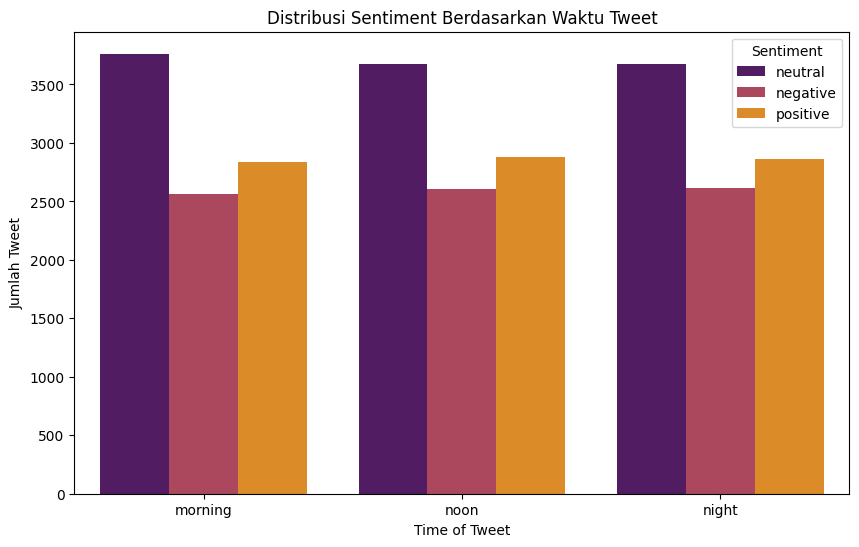

In [10]:
def get_top_n(words, n=20):
    all_words = ' '.join(words).lower()
    tokens = re.findall(r'\b\w+\b', all_words)
    counter = Counter(tokens)
    return counter.most_common(n)

for sentiment in train['sentiment'].unique():
    texts = train.loc[train['sentiment']==sentiment, 'text']
    top20 = get_top_n(texts, 20)
    print(f"\nTop 20 kata untuk sentiment {sentiment}:")
    print(top20)

# Analisis hubungan antara waktu tweet dan sentiment
plt.figure(figsize=(10,6))
sns.countplot(data=train, x='Time of Tweet', hue='sentiment', palette="inferno")
plt.title('Distribusi Sentiment Berdasarkan Waktu Tweet')
plt.ylabel('Jumlah Tweet')
plt.xlabel('Time of Tweet')
plt.legend(title='Sentiment')
plt.show()

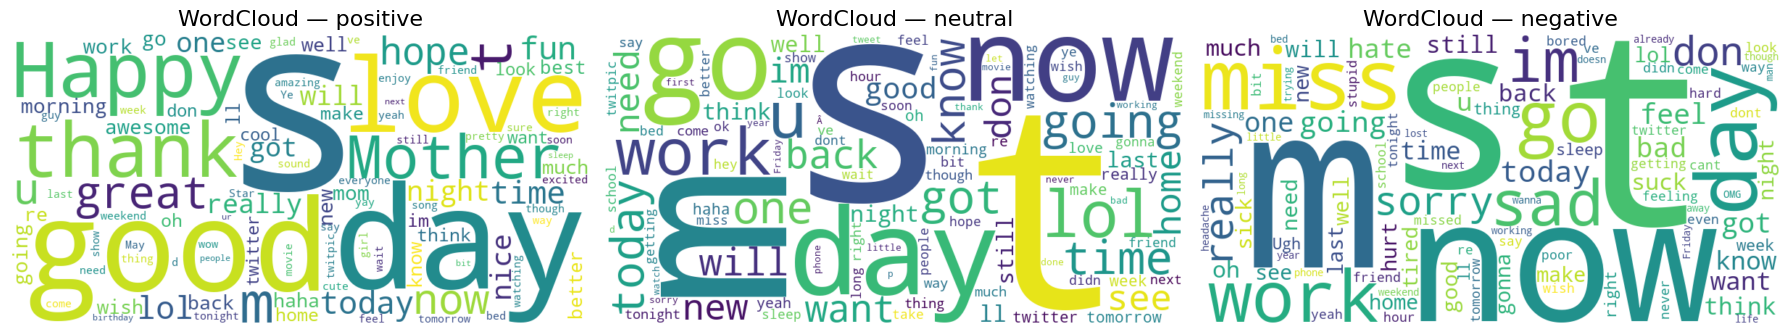

In [11]:
pos_text = ' '.join(train[train['sentiment']=='positive']['text'].dropna().tolist())
neu_text = ' '.join(train[train['sentiment']=='neutral']['text'].dropna().tolist())
neg_text = ' '.join(train[train['sentiment']=='negative']['text'].dropna().tolist())

texts = {
    'positive': pos_text,
    'neutral':  neu_text,
    'negative': neg_text
}

fig, axes = plt.subplots(1, 3, figsize=(18, 10))

for ax, (sentiment, txt) in zip(axes, texts.items()):
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=100,
        collocations=False
    ).generate(txt)
    
    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'WordCloud — {sentiment}', fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()


  Age of User  Age_of_User_Code
0        0-20                 1
1       21-30                 2
2       31-45                 3
3       46-60                 4
4       60-70                 5
5      70-100                 6


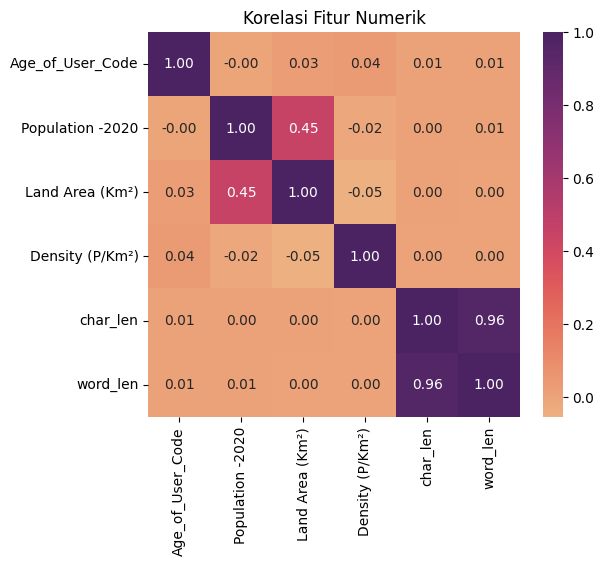

In [12]:
age_mapping = {
    '0-20':  1,
    '21-30': 2,
    '31-45': 3,
    '46-60': 4,
    '60-70': 5,
    '70-100': 6
}

train['Age_of_User_Code'] = train['Age of User'].map(age_mapping)

print(train[['Age of User', 'Age_of_User_Code']].drop_duplicates())

num_cols = [
    'Age_of_User_Code',
    'Population -2020',
    'Land Area (Km²)',
    'Density (P/Km²)',
    'char_len',
    'word_len'
]
corr = train[num_cols].corr()

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='flare')
plt.title('Korelasi Fitur Numerik')
plt.show()


kolom age of user masih bersifat categorical sehingga saya lakukan mapping

## Data Pre-processing

In [13]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/hazwanadh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/hazwanadh/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hazwanadh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
# Tweet tokenizer (khusus tweet)
tweet_tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)

# Lemmatizer untuk mengubah kata ke bentuk dasar
lemmatizer = WordNetLemmatizer()

# Stopwords Bahasa Inggris + ekstensi untuk tweet
stop_words = set(stopwords.words('english'))
extra_stops = {'rt','via','…','-','’'}
stop_words |= extra_stops

# Daftar contraction/slang
contractions = {
    "i'm": "i am", "can't": "cannot", "won't": "will not",
    "u": "you", "ur": "your", "gr8": "great", "luv": "love",
    "isdnt": "is not", "didnt": "did not", "dont": "do not", "bday": "birthday", "lol": "laugh out loud",
    "btw": "by the way", "imo": "in my opinion", "idk": "i do not know",
    "gonna": "going to", "wanna": "want to", "gotta": "got to",
    "cuz": "because", "thx": "thanks", "pls": "please", "b4": "before", "where'd": "where did",
    "what's": "what is", "who's": "who is", "how's": "how is",
    "there's": "there is", "here's": "here is", "let's": "let us", "it's": "it is",
    "that's": "that is", "she's": "she is", "he's": "he is",
    "they're": "they are", "we're": "we are", "you're": "you are",
    "wasn't": "was not", "weren't": "were not", "isn't": "is not",
    "hasn't": "has not", "haven't": "have not", "hadn't": "had not",
    "won't've": "will not have", "wouldn't've": "would not have",
    "shouldn't've": "should not have", "couldn't've": "could not have",
    "ain't": "is not", "ain't": "are not", "ain't": "have not", "I'll": "I will",
    "you'll": "you will", "he'll": "he will", "she'll": "she will",
    "we'll": "we will", "they'll": "they will", "I'll": "I will",
    "you'd": "you would", "he'd": "he would", "she'd": "she would",
    "we'd": "we would", "they'd": "they would", "I'd": "I would",
    "you've": "you have", "he's": "he has", "she's": "she has",
    "we've": "we have", "they've": "they have", "I've": "I have", "you're": "you are", "TGIF": "thank god it's friday",
    "TMI": "too much information", "YOLO": "you only live once",
    "FOMO": "fear of missing out", "BFF": "best friends forever",
    "BRB": "be right back", "TTYL": "talk to you later", "Gnight": "good night"
}

contractions diatas berisi slang untuk mempermudah model mencerna kata" yang uncommon sehingga mudah dipahami model

In [15]:
# Fungsi untuk ekspansi contraction/slang
def expand_contractions(text):
    for contr, full in contractions.items():
        text = re.sub(rf"\b{re.escape(contr)}\b", full, text)
    return text

# Fungsi untuk menandai negasi
def mark_negation(tokens):
    neg_terms = {"not","no","never","n't"}
    negated = False
    out = []
    for tok in tokens:
        if tok in neg_terms:
            negated = True
            out.append(tok)
        elif negated:
            out.append("NEG_" + tok)
            negated = False
        else:
            out.append(tok)
    return out

def preprocess_tweet(text):
    # Case folding
    text = text.lower()
    # Expand contractions/slang
    text = expand_contractions(text)
    # Remove URLs, handles, hashtags
    text = re.sub(r'http\S+|www\.\S+|@\w+|#\w+', ' ', text)
    # Remove digits
    text = re.sub(r'\d+', ' ', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize
    tokens = tweet_tokenizer.tokenize(text)
    # Negation handling
    tokens = mark_negation(tokens)
    # Lemmatize
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens]
    # Stopword removal & keep only alphabetic tokens
    tokens = [tok for tok in tokens if tok.isalpha() and tok not in stop_words]
    return tokens


In [16]:
train['tokens'] = train['text'].fillna('').apply(preprocess_tweet)
test ['tokens'] = test ['text'].fillna('').apply(preprocess_tweet)

train['clean_text'] = train['tokens'].apply(lambda toks: ' '.join(toks))
test ['clean_text'] = test ['tokens'].apply(lambda toks: ' '.join(toks))


In [17]:
# Tokenization & Padding
vocab_size   = 10000
embedding_dim = 100
max_len      = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(train['clean_text'])

# Convert to sequences
X_train_seq = tokenizer.texts_to_sequences(train['clean_text'])
X_test_seq  = tokenizer.texts_to_sequences(test ['clean_text'])

# Padding
X_train = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test  = pad_sequences(X_test_seq,  maxlen=max_len, padding='post', truncating='post')

# Encode Labels & Split Train/Validation
le = LabelEncoder()
y = le.fit_transform(train['sentiment'])

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y, test_size=0.2, stratify=y, random_state=42
)

In [18]:
samples = [
    "_i_am_jes YAY! congrats! i`m afraid to check my grades!",
    "Sooo SAD I will miss you here in San Diego!!!",
    "as much as i love to be hopeful",
    "Then you should check out http://twittersucks.com and connect with other tweeple who hate twitter"
]

df_samples = pd.DataFrame({'text': samples})

df_samples['tokens'] = df_samples['text'].apply(preprocess_tweet)

df_samples['clean_text'] = df_samples['tokens'].apply(lambda toks: ' '.join(toks))

display(df_samples)

,text,tokens,clean_text
0,_i_am_jes YAY! congrats! i`m afraid to check m...,"[iamjes, yay, congrats, im, afraid, check, grade]",iamjes yay congrats im afraid check grade
1,Sooo SAD I will miss you here in San Diego!!!,"[sooo, sad, miss, san, diego]",sooo sad miss san diego
2,as much as i love to be hopeful,"[much, love, hopeful]",much love hopeful
3,Then you should check out http://twittersucks....,"[check, connect, tweeple, hate, twitter]",check connect tweeple hate twitter


saya membuat sample tweet untuk menguji apakah kolom token dan clean_text sudah melakukan data processing secara baik atau belum

## Modelling

In [19]:
# Early Stopping & Learning Rate Scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

##### 1. Feedforward Neural Network (FNN)

**Deskripsi**

Model ini menggunakan embedding untuk mengubah kata menjadi representasi vektor, kemudian GlobalMaxPooling1D untuk mengekstrak fitur paling signifikan dari urutan. Setelah itu, Dense layer digunakan untuk proses klasifikasi akhir.

**Parameter Utama**

- `vocab_size`: Ukuran kamus, yaitu jumlah kata unik dalam dataset. Digunakan untuk mendefinisikan dimensi embedding agar setiap kata memiliki representasi yang berbeda.
- `embedding_dim`: Dimensi vektor embedding untuk setiap kata. Menentukan kekayaan semantik representasi setiap kata.
- `input_length`: Panjang maksimum urutan input (tweet). Penting untuk menyeragamkan panjang input melalui padding atau truncating.
- `Dense(128, activation='relu')`: Layer tersembunyi dengan 128 neuron dan fungsi aktivasi ReLU (Rectified Linear Unit), berfungsi untuk mempelajari pola non-linear dari fitur.
- `Dropout(0.3)`: Teknik regulasi yang secara acak menonaktifkan 30% neuron selama pelatihan untuk mencegah overfitting.
- `Dense(3, activation='softmax')`: Output layer dengan 3 neuron (sesuai jumlah kelas sentimen: negatif, netral, positif) dan fungsi aktivasi softmax untuk menghasilkan distribusi probabilitas kelas.


##### 2. Recurrent Neural Network (RNN) - SimpleRNN

**Deskripsi**

Model ini memanfaatkan SimpleRNN layer yang dirancang khusus untuk memproses data sekuensial, memungkinkan model untuk menangkap dependensi antar kata dalam urutan.

**Parameter Utama**

- `SimpleRNN(128, return_sequences=False)`: Layer RNN dengan 128 unit. return_sequences=False berarti hanya output dari timestep terakhir yang dikembalikan, ideal untuk tugas klasifikasi sekuensial.

*Catatan: Parameter lain (vocab_size, embedding_dim, input_length, Dropout, Dense) memiliki tujuan yang sama seperti pada FNN.*

##### 3. Bidirectional Long Short-Term Memory (Bi-LSTM)

**Deskripsi**

Menggunakan Bidirectional wrapper di sekitar LSTM layer. LSTM sangat efektif dalam menangani dependensi jangka panjang dalam data sekuensial. Pendekatan bidirectional memungkinkan model memproses urutan dari dua arah (maju dan mundur), sehingga menangkap konteks yang lebih komprehensif.

**Parameter Utama**

- `Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))`: Layer LSTM dengan 64 unit, diproses secara dua arah. dropout dan recurrent_dropout digunakan untuk mencegah overfitting dalam layer LSTM itu sendiri.
- `Dense(64, activation='relu')`: Layer tersembunyi tambahan setelah LSTM untuk pemrosesan fitur yang lebih mendalam.

*Catatan: Parameter lain (vocab_size, embedding_dim, input_length, Dropout, Dense) memiliki tujuan yang sama.*

##### 4. Gated Recurrent Unit (GRU)

**Deskripsi**
Model ini menggunakan dua GRU layer yang ditumpuk. GRU adalah alternatif yang lebih sederhana dan seringkali lebih cepat dibandingkan LSTM, namun tetap sangat efektif untuk memproses data sekuensial.

**Parameter Utama**

- `GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)`: Layer GRU pertama dengan 128 unit. return_sequences=True memastikan bahwa output dari setiap timestep diteruskan ke layer GRU berikutnya.
- `GRU(64, dropout=0.3, recurrent_dropout=0.3)`: Layer GRU kedua dengan 64 unit. return_sequences=False secara default karena ini adalah layer GRU terakhir sebelum output layer.

*Catatan: Parameter lain (vocab_size, embedding_dim, input_length, Dense) memiliki tujuan yang sama.*

##### 5. Convolutional Neural Network (CNN) - 1D

**Deskripsi**

Model ini menggunakan Conv1D layer yang sangat cocok untuk mengekstraksi fitur lokal (mirip dengan n-gram) dari teks. SpatialDropout1D diterapkan pada embedding untuk mencegah overfitting.

**Parameter Utama**

- `SpatialDropout1D(0.3)`: Versi dropout yang menjatuhkan seluruh feature map (dimensi embedding) daripada neuron individual, efektif untuk data sekuensial.
- `Conv1D(128, 5, activation='relu')`: Convolutional layer dengan 128 filter berukuran 5 (mencari pola 5 kata). Fungsi aktivasi ReLU.
- `GlobalMaxPooling1D()`: Mengambil nilai maksimum dari setiap feature map setelah konvolusi, merangkum fitur paling signifikan.

*Catatan: Parameter lain (vocab_size, embedding_dim, input_length, Dropout, Dense) memiliki tujuan yang sama.*

##### Kesimpulan

- **FNN**: Model sederhana dan cepat, cocok sebagai baseline
- **SimpleRNN**: Mampu menangkap dependensi sekuensial
- **Bi-LSTM**: Menangani dependensi jangka panjang dengan konteks dua arah
- **GRU**: Alternatif efisien dari LSTM dengan performa yang baik
- **CNN-1D**: Sangat baik dalam menangkap pola lokal teks dan fitur n-gram

In [20]:
def build_fnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        GlobalMaxPooling1D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_rnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        SimpleRNN(128, return_sequences=False),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_lstm(vocab_size, embedding_dim, input_length): ## Bidirectional LSTM
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        Bidirectional(LSTM(64, return_sequences=False, dropout=0.2, recurrent_dropout=0.2)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_gru(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        GRU(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        GRU(64, dropout=0.3, recurrent_dropout=0.3),
        Dense(3, activation='softmax')
    ])
    return model

def build_cnn(vocab_size, embedding_dim, input_length):
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=input_length),
        SpatialDropout1D(0.3),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])
    return model


In [21]:
fnn_model = build_fnn(vocab_size=10000, embedding_dim=100, input_length=50)
fnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_fnn = fnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5135 - loss: 0.9755 - val_accuracy: 0.6998 - val_loss: 0.7144 - learning_rate: 0.0010
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7749 - loss: 0.5721 - val_accuracy: 0.7066 - val_loss: 0.7136 - learning_rate: 0.0010
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8631 - loss: 0.3847 - val_accuracy: 0.6846 - val_loss: 0.7838 - learning_rate: 0.0010
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9187 - loss: 0.2512 - val_accuracy: 0.6802 - val_loss: 0.9086 - learning_rate: 0.0010
Epoch 5/20
535/550 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9576 - loss: 0.1469
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9574 - loss: 0.1473 - val_accuracy: 0.6611 - val_loss: 1.0683 - learning_rate: 0.0010
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9757 - loss: 0.0859 - v

In [22]:
rnn_model = build_rnn(vocab_size=10000, embedding_dim=100, input_length=50)
rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_rnn = rnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3655 - loss: 1.1216 - val_accuracy: 0.4057 - val_loss: 1.1054 - learning_rate: 0.0010
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.3638 - loss: 1.1272 - val_accuracy: 0.4073 - val_loss: 1.0900 - learning_rate: 0.0010
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3708 - loss: 1.0993 - val_accuracy: 0.4073 - val_loss: 1.0890 - learning_rate: 0.0010
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.4034 - loss: 1.0903 - val_accuracy: 0.4073 - val_loss: 1.0846 - learning_rate: 0.0010
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - accuracy: 0.3933 - loss: 1.0931 - val_accuracy: 0.3944 - val_loss: 1.0956 - learning_rate: 0.0010
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.3749 - loss: 1.1022 - val_accuracy: 0.3514 - val_loss: 1.0980 - learning_rate: 0.0010
Epoch 7/20
547/550 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3783 - lo

In [23]:
lstm_model = build_lstm(vocab_size=10000, embedding_dim=100, input_length=50)
lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_lstm = lstm_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 51s 88ms/step - accuracy: 0.5145 - loss: 0.9544 - val_accuracy: 0.6846 - val_loss: 0.7359 - learning_rate: 0.0010
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.7599 - loss: 0.5997 - val_accuracy: 0.6937 - val_loss: 0.7247 - learning_rate: 0.0010
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 52s 94ms/step - accuracy: 0.8161 - loss: 0.4927 - val_accuracy: 0.6971 - val_loss: 0.7748 - learning_rate: 0.0010
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 54s 99ms/step - accuracy: 0.8517 - loss: 0.4031 - val_accuracy: 0.6893 - val_loss: 0.8081 - learning_rate: 0.0010
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8744 - loss: 0.3515
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
550/550 ━━━━━━━━━━━━━━━━━━━━ 53s 96ms/step - accuracy: 0.8744 - loss: 0.3516 - val_accuracy: 0.6861 - val_loss: 0.9620 - learning_rate: 0.0010
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 53s 97ms/step - accuracy: 0.9014 - los

In [24]:
gru_model = build_gru(vocab_size=10000, embedding_dim=100, input_length=50)
gru_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_gru = gru_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 77s 136ms/step - accuracy: 0.3917 - loss: 1.0915 - val_accuracy: 0.4073 - val_loss: 1.0861 - learning_rate: 0.0010
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 73s 132ms/step - accuracy: 0.4007 - loss: 1.0892 - val_accuracy: 0.4073 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 73s 132ms/step - accuracy: 0.4062 - loss: 1.0878 - val_accuracy: 0.4073 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 73s 133ms/step - accuracy: 0.4010 - loss: 1.0892 - val_accuracy: 0.4073 - val_loss: 1.0855 - learning_rate: 0.0010
Epoch 5/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4005 - loss: 1.0889
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
550/550 ━━━━━━━━━━━━━━━━━━━━ 73s 133ms/step - accuracy: 0.4005 - loss: 1.0889 - val_accuracy: 0.4073 - val_loss: 1.0869 - learning_rate: 0.0010
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 76s 138ms/step - accuracy: 0.393

In [25]:
cnn_model = build_cnn(vocab_size=10000, embedding_dim=100, input_length=50)
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

history_cnn = cnn_model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5049 - loss: 0.9715 - val_accuracy: 0.6971 - val_loss: 0.7327 - learning_rate: 0.0010
Epoch 2/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - accuracy: 0.7464 - loss: 0.6275 - val_accuracy: 0.7032 - val_loss: 0.7238 - learning_rate: 0.0010
Epoch 3/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.8222 - loss: 0.4849 - val_accuracy: 0.6859 - val_loss: 0.7831 - learning_rate: 0.0010
Epoch 4/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.8710 - loss: 0.3655 - val_accuracy: 0.6741 - val_loss: 0.8929 - learning_rate: 0.0010
Epoch 5/20
548/550 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.2697
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
550/550 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.9062 - loss: 0.2698 - val_accuracy: 0.6639 - val_loss: 0.9916 - learning_rate: 0.0010
Epoch 6/20
550/550 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9347 - loss: 0.2014 - val_accu

## Evaluation & F1 Score

In [26]:
def plot_history(histories, model_names):
    plt.figure(figsize=(18, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['accuracy'], label=f'{name} Train')
        plt.plot(history.history['val_accuracy'], linestyle='--', label=f'{name} Val')
    plt.title('Model Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    for history, name in zip(histories, model_names):
        plt.plot(history.history['loss'], label=f'{name} Train')
        plt.plot(history.history['val_loss'], linestyle='--', label=f'{name} Val')
    plt.title('Model Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

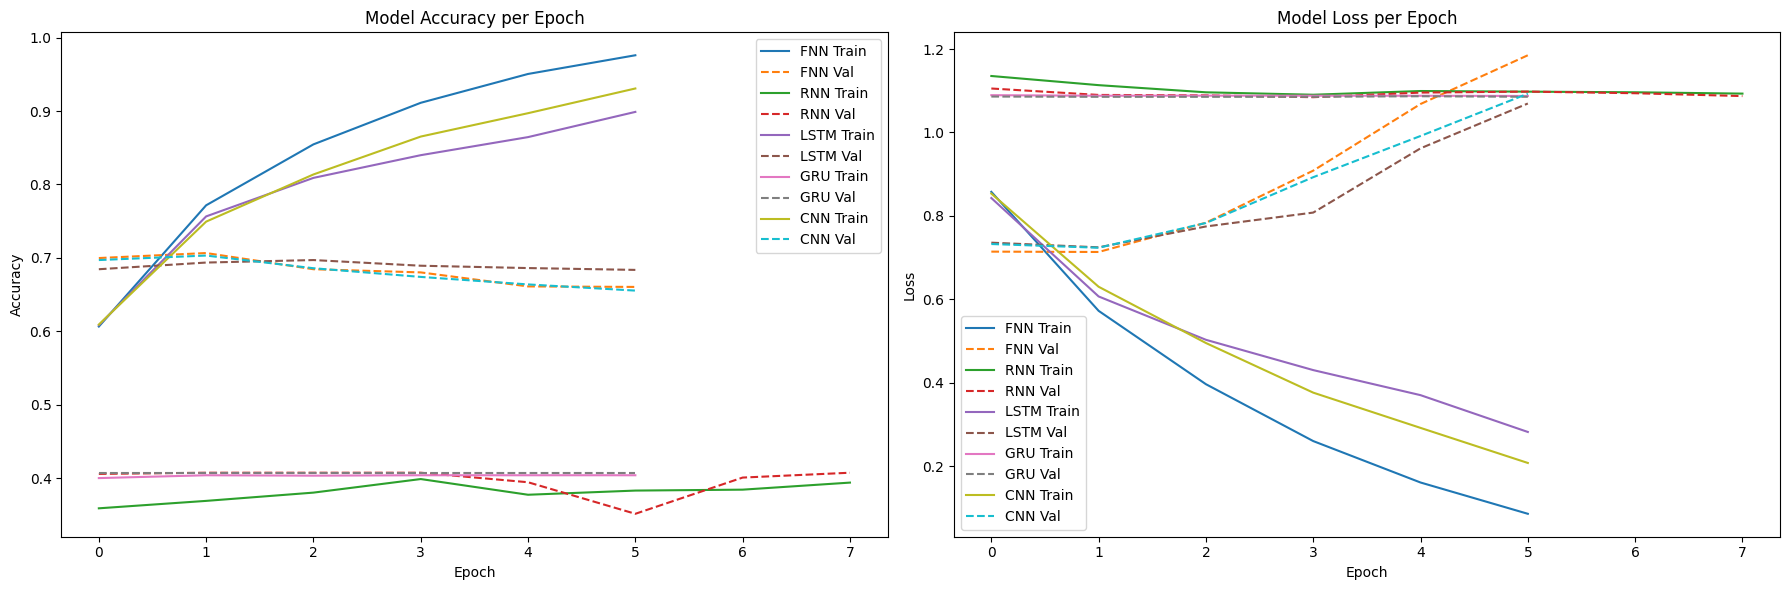

In [28]:
plot_history(
    [history_fnn, history_rnn, history_lstm, history_gru, history_cnn,],
    ['FNN', 'RNN', 'LSTM','GRU', 'CNN']
)

In [29]:
def evaluate_model(model, X_val, y_test, name):
    y_pred = model.predict(X_val)
    y_pred_labels = y_pred.argmax(axis=1)

    f1 = f1_score(y_test, y_pred_labels, average='weighted')
    print(f'\n📌 {name} - F1 Score: {f1:.4f}\n')
    print(classification_report(y_test, y_pred_labels, target_names=['Negative', 'Neutral', 'Positive']))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_labels)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 570us/step

📌 FNN - F1 Score: 0.7054

              precision    recall  f1-score   support

    Negative       0.67      0.69      0.68      1556
     Neutral       0.67      0.68      0.67      2223
    Positive       0.78      0.75      0.77      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.71      0.71      5496
weighted avg       0.71      0.70      0.71      5496



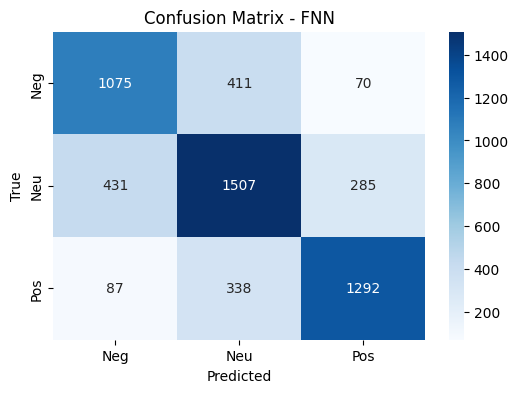

172/172 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

📌 RNN - F1 Score: 0.2330

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1556
     Neutral       0.40      1.00      0.58      2223
    Positive       0.00      0.00      0.00      1717

    accuracy                           0.40      5496
   macro avg       0.13      0.33      0.19      5496
weighted avg       0.16      0.40      0.23      5496



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

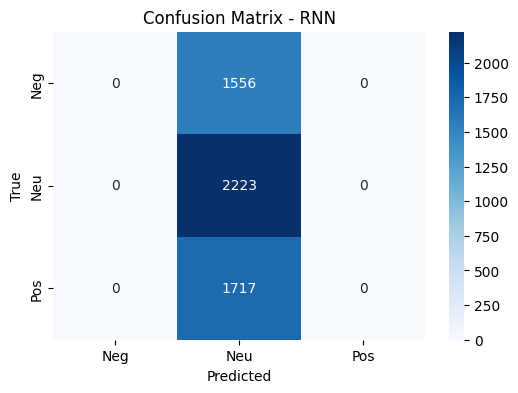

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step

📌 LSTM - F1 Score: 0.7018

              precision    recall  f1-score   support

    Negative       0.72      0.66      0.69      1556
     Neutral       0.66      0.67      0.67      2223
    Positive       0.74      0.78      0.76      1717

    accuracy                           0.70      5496
   macro avg       0.71      0.70      0.70      5496
weighted avg       0.70      0.70      0.70      5496



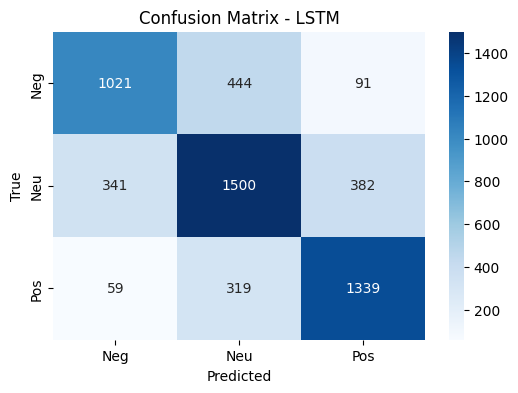

172/172 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step

📌 GRU - F1 Score: 0.2330

              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00      1556
     Neutral       0.40      1.00      0.58      2223
    Positive       0.00      0.00      0.00      1717

    accuracy                           0.40      5496
   macro avg       0.13      0.33      0.19      5496
weighted avg       0.16      0.40      0.23      5496



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

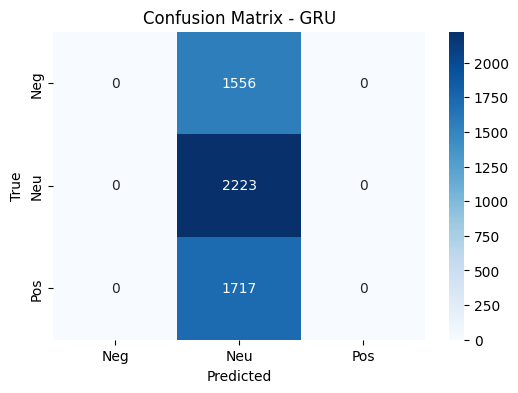

172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📌 CNN - F1 Score: 0.7092

              precision    recall  f1-score   support

    Negative       0.72      0.64      0.68      1556
     Neutral       0.67      0.70      0.68      2223
    Positive       0.76      0.78      0.77      1717

    accuracy                           0.71      5496
   macro avg       0.72      0.71      0.71      5496
weighted avg       0.71      0.71      0.71      5496



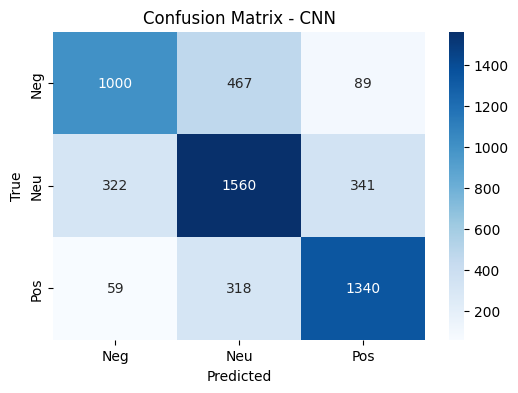

In [30]:
evaluate_model(fnn_model, X_val, y_val, 'FNN')
evaluate_model(rnn_model, X_val, y_val, 'RNN')
evaluate_model(lstm_model, X_val, y_val, 'LSTM')
evaluate_model(gru_model, X_val, y_val, 'GRU')
evaluate_model(cnn_model, X_val, y_val, 'CNN')

berdasarkan confusion matrix dan f1 score terlihat kinerja model FNN, CNN dan LTSM lebih baik dibandingkan yang lain

In [33]:
best_model = lstm_model  # JANGAN LUPA GANTI

probs = best_model.predict(X_test)      

pred_idx = probs.argmax(axis=1)

pred_labels = le.inverse_transform(pred_idx)

submission = pd.DataFrame({
    'textID':      test['textID'],
    'sentiment':   pred_labels
})

submission.to_csv('submission10.csv', index=False) # JANGAN LUPA UPDATE NAMA FILE
print("File submission.csv berhasil dibuat!")


111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
File submission.csv berhasil dibuat!
